## 0.Time Tracking

In [1]:
import datetime

# Record the start time
start_time = datetime.datetime.now()
print(f"Notebook started at: {start_time}")

Notebook started at: 2024-07-17 16:58:16.644563


## 1.Import Libraries

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Segmentation Models: using `keras` framework.


## 2.Define Paths and Read Filenames

In [3]:
base_path = r"D:\20BPS1134\ham10000"  # Change this to the path of your dataset
train_image_dir = os.path.join(base_path, 'images/train')
val_image_dir = os.path.join(base_path, 'images/val')
test_image_dir = os.path.join(base_path, 'images/test')
train_mask_dir = os.path.join(base_path, 'annotations/train')
val_mask_dir = os.path.join(base_path, 'annotations/val')
test_mask_dir = os.path.join(base_path, 'annotations/test')

train_ids = [line.strip() for line in open(os.path.join(base_path, 'train.txt'))]
val_ids = [line.strip() for line in open(os.path.join(base_path, 'val.txt'))]
test_ids = [line.strip() for line in open(os.path.join(base_path, 'test.txt'))]

## 3.Define Functions for Data Preparation

In [4]:
def resize_image(image, target_size):
    return image.resize(target_size, Image.BICUBIC)

def load_image(path, target_size=(384, 384)):
    image = Image.open(path)
    image = resize_image(image, target_size)
    return img_to_array(image) / 255.0

def load_mask(path, target_size=(384, 384)):
    mask = Image.open(path).convert("L")
    mask = resize_image(mask, target_size)
    mask = img_to_array(mask) / 255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

class DataGenerator(Sequence):
    def __init__(self, list_ids, image_dir, mask_dir, batch_size=4, image_size=(384, 384), augment=False, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.list_ids = list_ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.list_ids[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        for id in batch_ids:
            image = load_image(os.path.join(self.image_dir, id + '.jpg'), self.image_size)
            mask = load_mask(os.path.join(self.mask_dir, id + '.png'), self.image_size)
            if self.augment:
                # Apply data augmentation here if needed
                pass
            images.append(image)
            masks.append(mask)
        return np.array(images), np.array(masks)

    def get_filenames(self, index):
        batch_ids = self.list_ids[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_ids

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.list_ids)

# Instantiate data generators
train_gen = DataGenerator(train_ids, train_image_dir, train_mask_dir, batch_size=4, image_size=(384, 384))
val_gen = DataGenerator(val_ids, val_image_dir, val_mask_dir, batch_size=4, image_size=(384, 384))
test_gen = DataGenerator(test_ids, test_image_dir, test_mask_dir, batch_size=4, image_size=(384, 384))

## 4.Define the Combined Loss Function

In [5]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    dice_loss = sm.losses.DiceLoss()(y_true, y_pred)
    binary_focal_loss = sm.losses.BinaryFocalLoss()(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return dice_loss + binary_focal_loss + ssim

## 5.Define the EfficientNetB4-UNet Based Encoder and Decoder with 5 layers

In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, Dropout, UpSampling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, GlobalMaxPooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import LeakyReLU


# Define the Convolution Block
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# Define the Transpose Convolution Block
def decoder_block(input, skip_features, num_filters, dropout_rate=0.5):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Dropout(dropout_rate)(x)
    x = conv_block(x, num_filters)
    return x

# Squeeze operation
def squeeze_operation(input_feature):
    H, W, C = K.int_shape(input_feature)[1], K.int_shape(input_feature)[2], K.int_shape(input_feature)[3]
    return K.sum(input_feature, axis=[1, 2]) / (H * W)

# Channel Attention Module (CAM)
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Shared dense layers
    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Global Average Pooling path
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = squeeze_operation(avg_pool)  # Apply squeeze operation
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Global Max Pooling path
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = squeeze_operation(max_pool)  # Apply squeeze operation
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # Combine and apply sigmoid activation to create attention map
    combined = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(combined)

    # Scale the input feature map by the attention map
    return multiply([input_feature, cbam_feature])

def distance_transform(S):
    # Approximation of distance transform using convolution
    S = tf.cast(S, tf.float32)
    S = 1 - S  # Invert binary mask
    S = tf.nn.conv2d(S, filters=tf.ones((5, 5, S.shape[-1], S.shape[-1])), strides=[1, 1, 1, 1], padding='SAME')
    return S
    
# Custom Layer to Calculate Distance Transform using TensorFlow operations
def calculate_di(Si, inv_Si):
    DT_Si = distance_transform(Si)
    DT_inv_Si = distance_transform(inv_Si)

    max_DT_Si = tf.reduce_max(DT_Si, axis=[1, 2], keepdims=True)
    max_DT_inv_Si = tf.reduce_max(DT_inv_Si, axis=[1, 2], keepdims=True)

    Di = (DT_Si / max_DT_Si) + (DT_inv_Si / max_DT_inv_Si)
    return Di

# Define the Edge Attention Module (EAM)
def edge_attention_module(s3, s4, final_decoder_output, num_filters):
    # Using s3 and s4 as initial feature maps 
    s3 = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(s3)
    s3 = BatchNormalization()(s3)
    s3 = LeakyReLU(alpha=0.2)(s3)
    
    s4 = UpSampling2D(size=(2, 2))(s4)  # Adjust the upsampling size to match dimensions
    s4 = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(s4)
    s4 = BatchNormalization()(s4)
    s4 = LeakyReLU(alpha=0.2)(s4) 
    
    combined = Concatenate(axis=-1)([s3, s4]) # Depth Concatenation
    combined = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(combined)
    combined = BatchNormalization()(combined)
    combined = LeakyReLU(alpha=0.2)(combined)

    # Using final_decoder_output as PPD output
    final_map = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(final_decoder_output)
    final_map = BatchNormalization()(final_map)
    final_map = LeakyReLU(alpha=0.2)(final_map)
    
    # Boundary Attention operations
    boundary = tf.sigmoid(final_map)
    inv_boundary = 1 - boundary
    
    Di = calculate_di(boundary, inv_boundary)
    Mi_B = 1 - Di
    
    # Ensure that dimensions match before multiplication
    combined = UpSampling2D(size=(4, 4))(combined)  # Adjust the upsampling size to match Mi_B dimensions
    enhanced_boundary = combined * Mi_B
    enhanced_boundary = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(enhanced_boundary)
    enhanced_boundary = BatchNormalization()(enhanced_boundary)
    enhanced_boundary = LeakyReLU(alpha=0.2)(enhanced_boundary)
    
    return enhanced_boundary

# Define the Reverse Attention (RA) Module
def reverse_attention_module(Ui_plus_1, Fi, Ob, num_filters):
    # Print the shapes of Fi and Ob
    print("Fi shape before any operation:", Fi.shape)
    print("Ob shape before any operation:", Ob.shape)

    # Calculate the downsampling factors
    factor_h = Ob.shape[1] // Fi.shape[1] if Ob.shape[1] // Fi.shape[1] > 0 else 1
    factor_w = Ob.shape[2] // Fi.shape[2] if Ob.shape[2] // Fi.shape[2] > 0 else 1

    # Downsample Ob to match Fi dimensions
    Ob_downsampled = Conv2D(num_filters, 1, padding="same", strides=(factor_h, factor_w))(Ob)
    Ob_downsampled = BatchNormalization()(Ob_downsampled)
    Ob_downsampled = LeakyReLU(alpha=0.2)(Ob_downsampled)
    
    # Print the shape of Ob_downsampled
    print("Ob_downsampled shape:", Ob_downsampled.shape)

    # Depth Concatenation of Ob_downsampled with Fi
    Fi_concat = Concatenate(axis=-1)([Fi, Ob_downsampled])
    print("Ob_Fi_Concatenated shape:", Fi_concat.shape)

    # Convolution operations to reduce the number of channels to num_filters
    Fi_concat_conv = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(Fi_concat)
    Fi_concat_conv = BatchNormalization()(Fi_concat_conv)
    Fi_concat_conv = LeakyReLU(alpha=0.2)(Fi_concat_conv)

    Fi_concat_conv = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(Fi_concat_conv)
    Fi_concat_conv = BatchNormalization()(Fi_concat_conv)
    Fi_concat_conv = LeakyReLU(alpha=0.2)(Fi_concat_conv)

    # Apply sigmoid activation to the Ui_plus_1
    Si = tf.sigmoid(Ui_plus_1)

    # Inverse of Si
    inv_Si = 1 - Si

    # Ensure that dimensions match before multiplication
    Fi_concat_conv = UpSampling2D(size=(Ui_plus_1.shape[1] // Fi_concat_conv.shape[1], Ui_plus_1.shape[2] // Fi_concat_conv.shape[2]))(Fi_concat_conv)
    print("Fi_Concatenated_upsampled shape:", Fi_concat_conv.shape)
    print("inv_Si shape:", inv_Si.shape)
    # Element-wise multiplication with inv_Si
    refined_feature = Fi_concat_conv * inv_Si
    print("RA_ouput shape", refined_feature.shape)
    return refined_feature

# Build the EfficientNetB4_UNet with EAM and RA applied
def build_efficientNetB4_unet_with_ra(input_shape, dropout_rate=0.5):
    inputs = Input(shape=input_shape, name='input_image')

    # Load pre-trained EfficientNetB4 model
    effNetB4 = EfficientNetB4(input_tensor=inputs, include_top=False, weights='imagenet')

    # Ensure all layers are trainable
    for layer in effNetB4.layers:
        layer.trainable = True

    # Encoder
    s1 = effNetB4.get_layer("input_image").output                       
    s2 = effNetB4.get_layer("block1a_activation").output                 
    s3 = effNetB4.get_layer("block2a_activation").output                 
    s4 = effNetB4.get_layer("block3a_activation").output                 
    s5 = effNetB4.get_layer("block4a_activation").output                
    b1 = effNetB4.get_layer("block7a_activation").output                 

    # Decoder
    d1 = decoder_block(b1, s5, 256, dropout_rate)                        
    d1 = channel_attention(d1)                                           
    d2 = decoder_block(d1, s4, 128, dropout_rate)                        
    d3 = decoder_block(d2, s3, 64, dropout_rate)                         
    d3 = channel_attention(d3)                                          
    d4 = decoder_block(d3, s2, 32, dropout_rate)                         
    d5 = decoder_block(d4, s1, 16, dropout_rate)                         
    d5 = channel_attention(d5)                                           
    
    # Apply EAM
    enhanced_boundary = edge_attention_module(s3, s4, d5, 16)

    # RA1: Takes d5, b1, and enhanced_boundary
    RA1_output = reverse_attention_module(d5, b1, enhanced_boundary, 16)
    RA1_sum = Add()([RA1_output, d5])

    # RA2: Takes RA1_sum, s5, and enhanced_boundary
    RA2_output = reverse_attention_module(RA1_sum, s5, enhanced_boundary, 16)
    RA2_sum = Add()([RA2_output, RA1_sum])

    # Final convolution to produce the segmentation mask
    final_output = Conv2D(1, 1, padding="same", activation="sigmoid")(RA2_sum)

    model = Model(inputs, final_output, name="EfficientNetB4_UNet_RA")
    return model

def save_feature_maps(model, validation_data, feature_map_names, epoch, dir_name='EAM_featureMaps'):
    val_batch = next(iter(validation_data))
    sample_input, _ = val_batch
    filenames = validation_data.get_filenames(0)

    sample_output = model(sample_input, training=False)

    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    for i in range(sample_input.shape[0]):
        plt.imshow(sample_input[i])
        plt.axis('off')
        plt.savefig(f'{dir_name}/input_{filenames[i]}_epoch_{epoch}_sample_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[layer.output for layer in model.layers])
    feature_maps = intermediate_layer_model.predict(sample_input)

    for i, feature_map in enumerate(feature_maps[-len(feature_map_names):]):
        for j in range(feature_map.shape[-1]):
            plt.imshow(feature_map[0, :, :, j], cmap='gray')
            plt.axis('off')
            plt.savefig(f'{dir_name}/{feature_map_names[i]}_{filenames[0]}_epoch_{epoch}_channel_{j}.png', bbox_inches='tight', pad_inches=0)
            plt.close()


def save_feature_maps_callback(model, validation_data, feature_map_names, dir_name='EAM_featureMaps'):
    return LambdaCallback(on_epoch_end=lambda epoch, logs: save_feature_maps(model, validation_data, feature_map_names, epoch, dir_name))
    
feature_map_names = ["Ui", "Si", "inverse_Si", "Di", "Mi_B", "Ob"]

def save_feature_maps_ra(model, validation_data, feature_map_names, ra_type, epoch, dir_name='RA_FeatureMaps'):
    val_batch = next(iter(validation_data))
    sample_input, _ = val_batch
    filenames = validation_data.get_filenames(0)

    ra_dir = os.path.join(dir_name, ra_type)
    if not os.path.exists(ra_dir):
        os.makedirs(ra_dir)

    for i in range(sample_input.shape[0]):
        plt.imshow(sample_input[i])
        plt.axis('off')
        plt.savefig(f'{ra_dir}/input_{filenames[i]}_epoch_{epoch}_sample_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[layer.output for layer in model.layers])
    feature_maps = intermediate_layer_model.predict(sample_input)

    for i, feature_map in enumerate(feature_maps[-len(feature_map_names):]):
        for j in range(feature_map.shape[-1]):
            plt.imshow(feature_map[0, :, :, j], cmap='gray')
            plt.axis('off')
            plt.savefig(f'{ra_dir}/{feature_map_names[i]}_{filenames[0]}_epoch_{epoch}_channel_{j}.png', bbox_inches='tight', pad_inches=0)
            plt.close()

def save_feature_maps_callback_ra1(model, validation_data, feature_map_names, dir_name='RA_FeatureMaps'):
    return LambdaCallback(on_epoch_end=lambda epoch, logs: save_feature_maps_ra(model, validation_data, feature_map_names, "RA1", epoch, dir_name))

def save_feature_maps_callback_ra2(model, validation_data, feature_map_names, dir_name='RA_FeatureMaps'):
    return LambdaCallback(on_epoch_end=lambda epoch, logs: save_feature_maps_ra(model, validation_data, feature_map_names, "RA2", epoch, dir_name))

# Define feature map names specific for RA modules
feature_map_names_ra1 = ["RA1_Ui", "RA1_Ob", "RA1_Fi", "RA1_Si", "RA1_inverse_Si", "RA1_combined", "RA1_output"]
feature_map_names_ra2 = ["RA2_Ui", "RA2_Ob", "RA2_Fi", "RA2_Si", "RA2_inverse_Si", "RA2_combined", "RA2_output"]

# Compile and train the model
if __name__ == "__main__":
    IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS = 384, 384, 3
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
    model = build_efficientNetB4_unet_with_ra(input_shape, dropout_rate=0.5)
    model.summary()

# Compile the model
learning_rate = 1e-3
optim = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
    ssim_metric
]

model.compile(optimizer=optim, loss=combined_loss, metrics=metrics)

71686520/71686520 [==============================] - 7s 0us/step
Fi shape before any operation: (None, 12, 12, 1632)
Ob shape before any operation: (None, 384, 384, 16)
Ob_downsampled shape: (None, 12, 12, 16)
Ob_Fi_Concatenated shape: (None, 12, 12, 1648)
Fi_Concatenated_upsampled shape: (None, 384, 384, 16)
inv_Si shape: (None, 384, 384, 16)
RA_ouput shape (None, 384, 384, 16)
Fi shape before any operation: (None, 24, 24, 336)
Ob shape before any operation: (None, 384, 384, 16)
Ob_downsampled shape: (None, 24, 24, 16)
Ob_Fi_Concatenated shape: (None, 24, 24, 352)
Fi_Concatenated_upsampled shape: (None, 384, 384, 16)
inv_Si shape: (None, 384, 384, 16)
RA_ouput shape (None, 384, 384, 16)
Model: "EfficientNetB4_UNet_RA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 384, 384, 3  0           []      

## 6.Callbacks

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callbacks
callbacks = [
    save_feature_maps_callback(model, val_gen, feature_map_names),
    save_feature_maps_callback_ra1(model, val_gen, feature_map_names_ra1),
    save_feature_maps_callback_ra2(model, val_gen, feature_map_names_ra2),
    # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

## 7.Train the Model

In [9]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=50,
    callbacks=callbacks 
)

Epoch 1/50
1752/1752 [==============================] - 969s 535ms/step - loss: 0.3894 - iou_score: 0.8168 - f1-score: 0.8948 - accuracy: 0.0011 - precision: 0.9055 - recall: 0.8826 - ssim_metric: 0.8067 - val_loss: 2.7450 - val_iou_score: 0.3190 - val_f1-score: 0.4742 - val_accuracy: 0.0000e+00 - val_precision: 0.3225 - val_recall: 0.9697 - val_ssim_metric: 0.3054 - lr: 0.0010
Epoch 2/50
1752/1752 [==============================] - 964s 550ms/step - loss: 0.2334 - iou_score: 0.8596 - f1-score: 0.9220 - accuracy: 5.3381e-04 - precision: 0.9377 - recall: 0.9068 - ssim_metric: 0.9104 - val_loss: 1.3732 - val_iou_score: 0.2275 - val_f1-score: 0.3561 - val_accuracy: 8.3171e-05 - val_precision: 0.8459 - val_recall: 0.2292 - val_ssim_metric: 0.6843 - lr: 0.0010
Epoch 3/50
1752/1752 [==============================] - 942s 538ms/step - loss: 0.2126 - iou_score: 0.8718 - f1-score: 0.9295 - accuracy: 7.4586e-04 - precision: 0.9433 - recall: 0.9148 - ssim_metric: 0.9169 - val_loss: 2.4259 - val_i

## 8.Save the Model Architecture

In [10]:
# # Save the model architecture diagram
# plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

## 9.Save the Model

In [11]:
# # Save the entire model using SavedModel format
# model.save("EfficientNetB4_UNet_final", save_format="tf")

## 10.Load the Model

In [12]:
# # Skip executing this block if you are training it for the first time, if you want to laod the model and use it directly for results without retraining it then load this block.
# # Custom SSIM metric function
# def ssim_metric(y_true, y_pred):
#     return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# # Combined loss function used during training
# def combined_loss(y_true, y_pred):
#     ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
#     dice_loss = sm.losses.DiceLoss()(y_true, y_pred)
#     binary_focal_loss = sm.losses.BinaryFocalLoss()(y_true, y_pred)
#     return ssim_loss + dice_loss + binary_focal_loss

# # Custom objects for the custom loss function and SSIM metric
# custom_objects = {
#     'combined_loss': combined_loss,
#     'iou_score': sm.metrics.iou_score,
#     'f1-score': sm.metrics.f1_score,
#     'precision': tf.keras.metrics.Precision(),
#     'recall': tf.keras.metrics.Recall(),
#     'ssim_metric': ssim_metric
# }

# # Load the trained model
# model_save_path = r"E:\Study stuff\Publications\SRIP\Existing Model Result Gathering\Segmentation_Models_Library\PSPNet\HAM10000_PSPNET_RESNET50\HAM10000_PSPNet_ResNet50.h5"
# loaded_model = load_model(model_save_path, custom_objects=custom_objects)

# # Verify the model is loaded correctly
# loaded_model.summary()

## 11.Evaluate the Model

In [13]:
# Evaluate the model on the validation set
val_loss, val_iou, val_fscore, val_accuracy, val_precision, val_recall, val_ssim = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation IOU: {val_iou}")
print(f"Validation FScore: {val_fscore}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation SSIM: {val_ssim}")

# Evaluate the model on the test set
test_loss, test_iou, test_fscore, test_accuracy, test_precision, test_recall, test_ssim = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test FScore: {test_fscore}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test SSIM: {test_ssim}")

500/500 [==============================] - 68s 136ms/step - loss: 0.1560 - iou_score: 0.9086 - f1-score: 0.9511 - accuracy: 3.2459e-04 - precision: 0.9505 - recall: 0.9504 - ssim_metric: 0.9358
Validation Loss: 0.15599162876605988
Validation IOU: 0.908634603023529
Validation FScore: 0.9510766267776489
Validation Accuracy: 0.0003245917323511094
Validation Precision: 0.950520932674408
Validation Recall: 0.9503598213195801
Validation SSIM: 0.9358404278755188
250/250 [==============================] - 45s 178ms/step - loss: 0.1676 - iou_score: 0.8992 - f1-score: 0.9457 - accuracy: 3.2073e-04 - precision: 0.9460 - recall: 0.9452 - ssim_metric: 0.9328
Test Loss: 0.16756117343902588
Test IOU: 0.899243950843811
Test FScore: 0.9457053542137146
Test Accuracy: 0.0003207329718861729
Test Precision: 0.9460062384605408
Test Recall: 0.9452415704727173
Test SSIM: 0.932809054851532


## 12.Visualize Training and Validation Loss

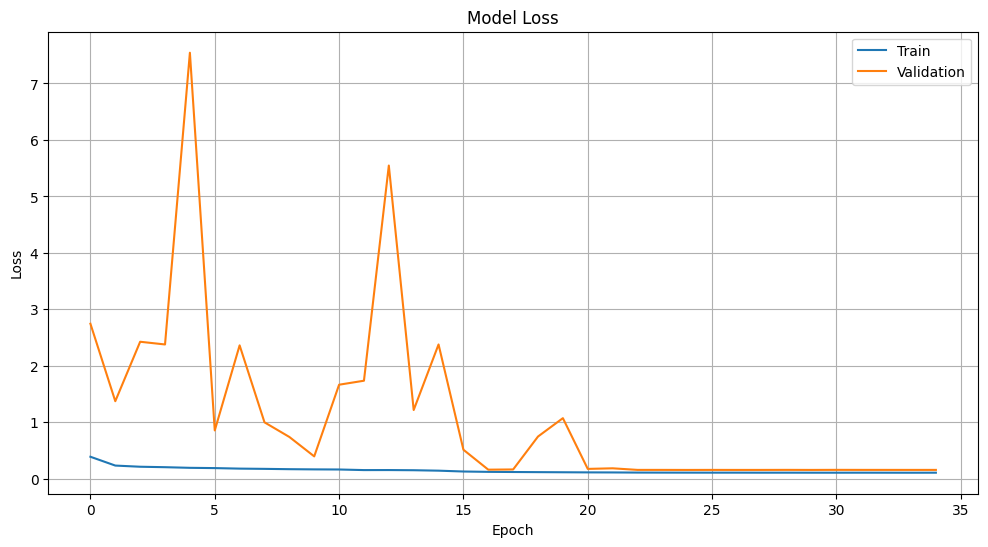

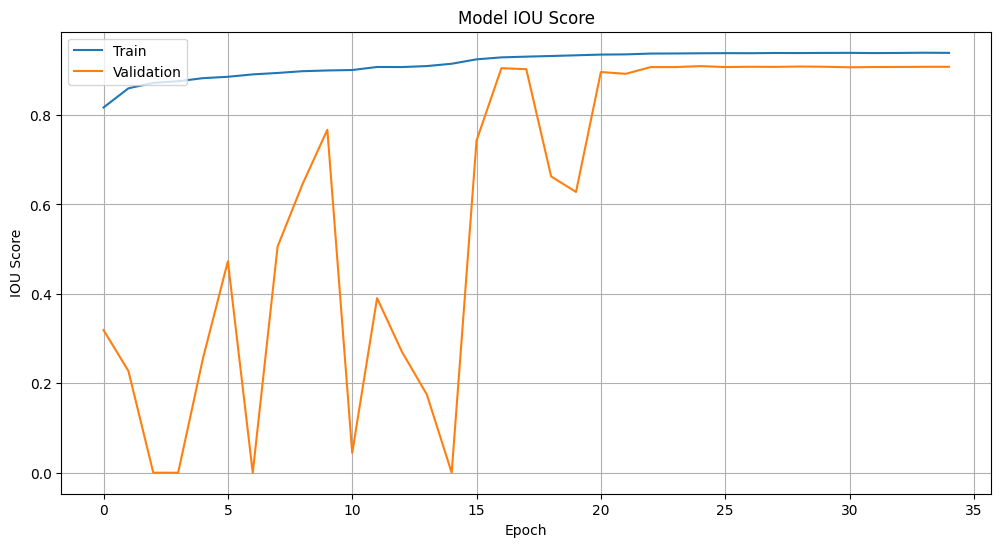

In [14]:
# Plot training & validation loss values
output_dir = r"D:\20BPS1134\Implementation\RA\3"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'loss.png'))
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.xlabel('Epoch')
plt.ylabel('IOU Score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'iou_score.png'))
plt.show()

## 13.Visualize Results for 3 Images

1/1 [==============================] - 3s 3s/step


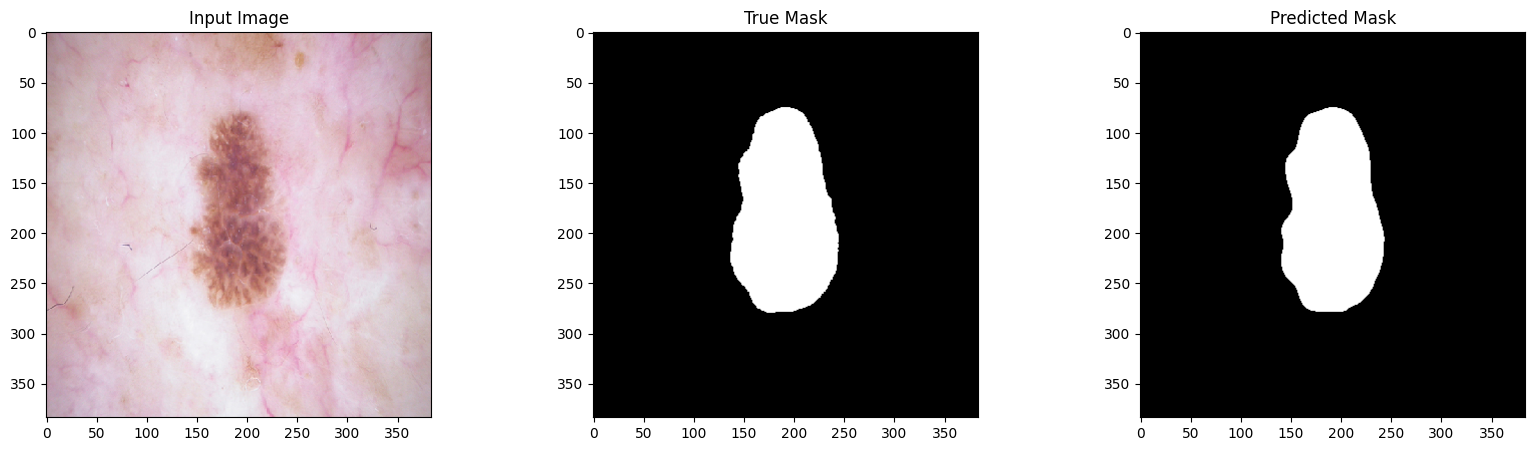

In [15]:
# Function to load and preprocess image
def load_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(384, 384))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return img

# Function to load mask
def load_mask(mask_path):
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(384, 384), color_mode="grayscale")
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    mask = mask / 255.0
    return mask

# Function to visualize predictions
def plot_predictions(model, image, mask, output_dir, img_index):
    pred_mask = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.round(pred_mask[0])
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask.squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    
    # Save the figure
    result_path = os.path.join(output_dir, f'result_{img_index}.png')
    plt.savefig(result_path, bbox_inches='tight')
    plt.show()
    plt.close()

# Create output directory if it doesn't exist
output_dir = r"D:\20BPS1134\Implementation\RA\3\HAM10000_Results"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate one image
sample_index = np.random.choice(len(test_ids), 1, replace=False)[0]
sample_image_path = os.path.join(test_image_dir, test_ids[sample_index] + '.jpg')
sample_mask_path = os.path.join(test_mask_dir, test_ids[sample_index] + '.png')

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 1  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 25ms/step


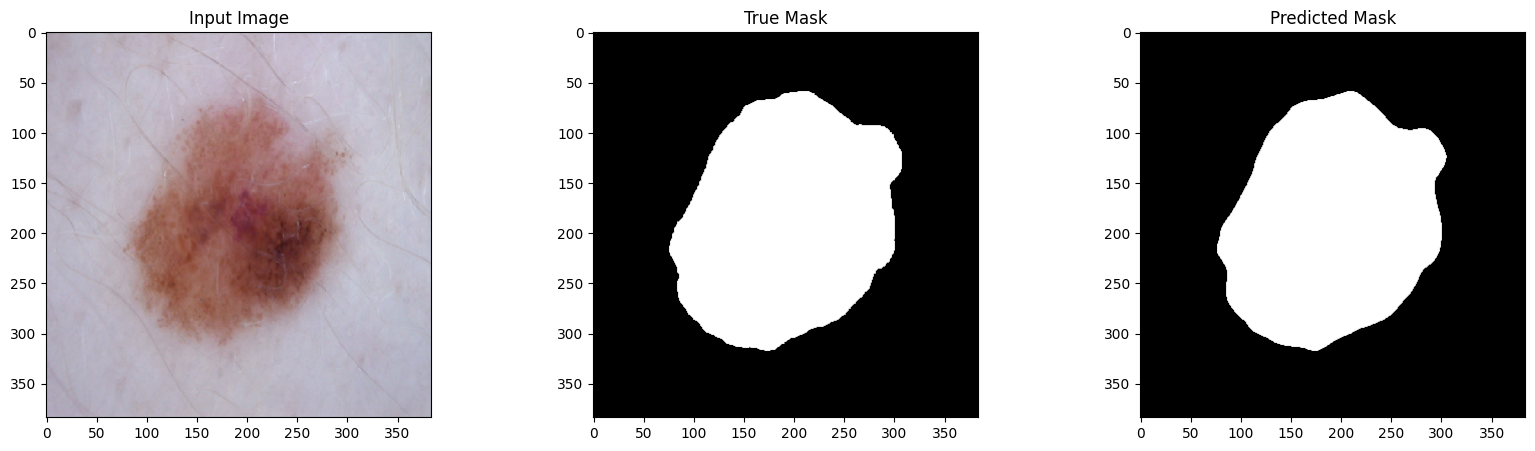

In [16]:
# Generate one image
sample_index = np.random.choice(len(test_ids), 1, replace=False)[0]
sample_image_path = os.path.join(test_image_dir, test_ids[sample_index] + '.jpg')
sample_mask_path = os.path.join(test_mask_dir, test_ids[sample_index] + '.png')

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 2  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 33ms/step


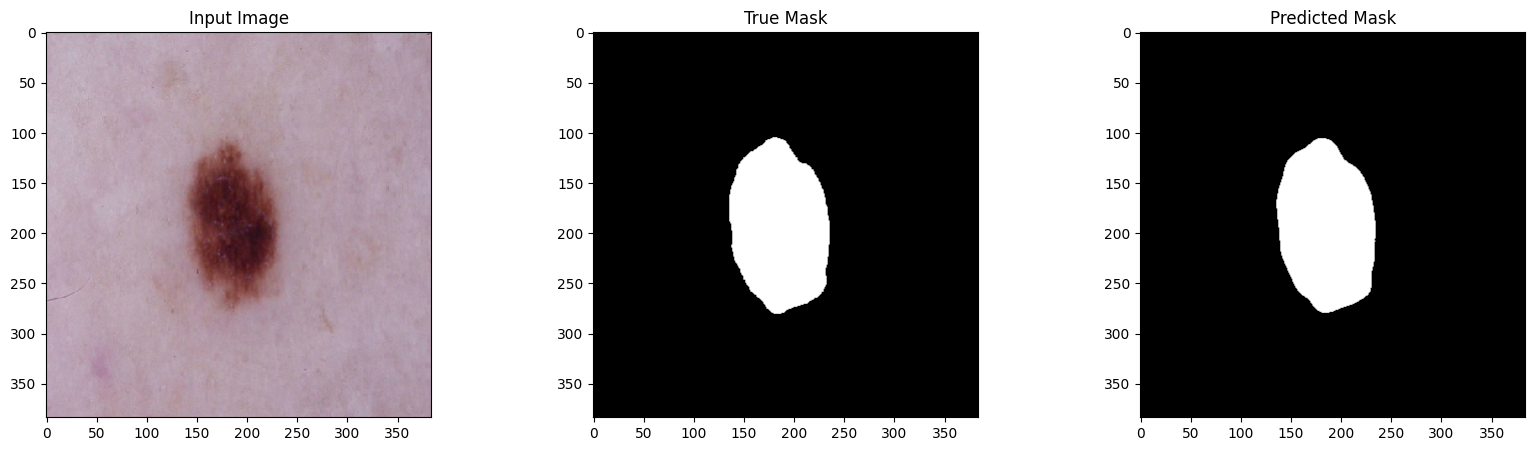

In [17]:
# Generate one image
sample_index = np.random.choice(len(test_ids), 1, replace=False)[0]
sample_image_path = os.path.join(test_image_dir, test_ids[sample_index] + '.jpg')
sample_mask_path = os.path.join(test_mask_dir, test_ids[sample_index] + '.png')

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 3  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

# TESTING THE MODEL ON DIFFERENT DATASET:- PH2 DATASET

## 14.Load PH2 Dataset

In [18]:
ph2_base_path = r"D:\20BPS1134\PH2Dataset\PH2 Dataset images"

ph2_image_dirs = [os.path.join(ph2_base_path, d, f"{d}_Dermoscopic_Image", f"{d}.bmp") for d in os.listdir(ph2_base_path)]
ph2_mask_dirs = [os.path.join(ph2_base_path, d, f"{d}_lesion", f"{d}_lesion.bmp") for d in os.listdir(ph2_base_path)]

# Shuffle the data
combined = list(zip(ph2_image_dirs, ph2_mask_dirs))
np.random.shuffle(combined)
ph2_image_dirs, ph2_mask_dirs = zip(*combined)

## 15.Define Data Generator for PH2 Dataset

In [19]:
def resize_image(image, target_size):
    return image.resize(target_size, Image.BICUBIC)

def load_image(path, target_size=(384, 384)):
    image = Image.open(path)
    image = resize_image(image, target_size)
    return img_to_array(image) / 255.0

def load_mask(path, target_size=(384, 384)):
    mask = Image.open(path).convert("L")
    mask = resize_image(mask, target_size)
    mask = img_to_array(mask) / 255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

class PH2DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size=4, image_size=(384, 384), shuffle=True):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            image = load_image(img_file, self.image_size)
            mask = load_mask(mask_file, self.image_size)
            images.append(image)
            masks.append(mask)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_files, self.mask_files))
            np.random.shuffle(combined)
            self.image_files, self.mask_files = zip(*combined)

# Instantiate data generator
ph2_gen = PH2DataGenerator(ph2_image_dirs, ph2_mask_dirs, batch_size=4, image_size=(384, 384))

## 16.Evaluate the Model on PH2 Dataset

In [20]:
ph2_loss, ph2_iou, ph2_fscore, ph2_accuracy, ph2_precision, ph2_recall, ph2_ssim = model.evaluate(ph2_gen)
print(f"PH2 Loss: {ph2_loss}")
print(f"PH2 IOU Score: {ph2_iou}")
print(f"PH2 FScore: {ph2_fscore}")
print(f"PH2 Accuracy: {ph2_accuracy}")
print(f"PH2 Precision: {ph2_precision}")
print(f"PH2 Recall: {ph2_recall}")
print(f"PH2 SSIM: {ph2_ssim}")

50/50 [==============================] - 12s 241ms/step - loss: 0.3165 - iou_score: 0.8464 - f1-score: 0.9153 - accuracy: 1.3652e-04 - precision: 0.8767 - recall: 0.9582 - ssim_metric: 0.8933
PH2 Loss: 0.31646105647087097
PH2 IOU Score: 0.8463524580001831
PH2 FScore: 0.9153205156326294
PH2 Accuracy: 0.0001365153002552688
PH2 Precision: 0.8766900897026062
PH2 Recall: 0.9582382440567017
PH2 SSIM: 0.8932906985282898


## 17.Visualize and Save Results for 3 Images from PH2

1/1 [==============================] - 0s 31ms/step


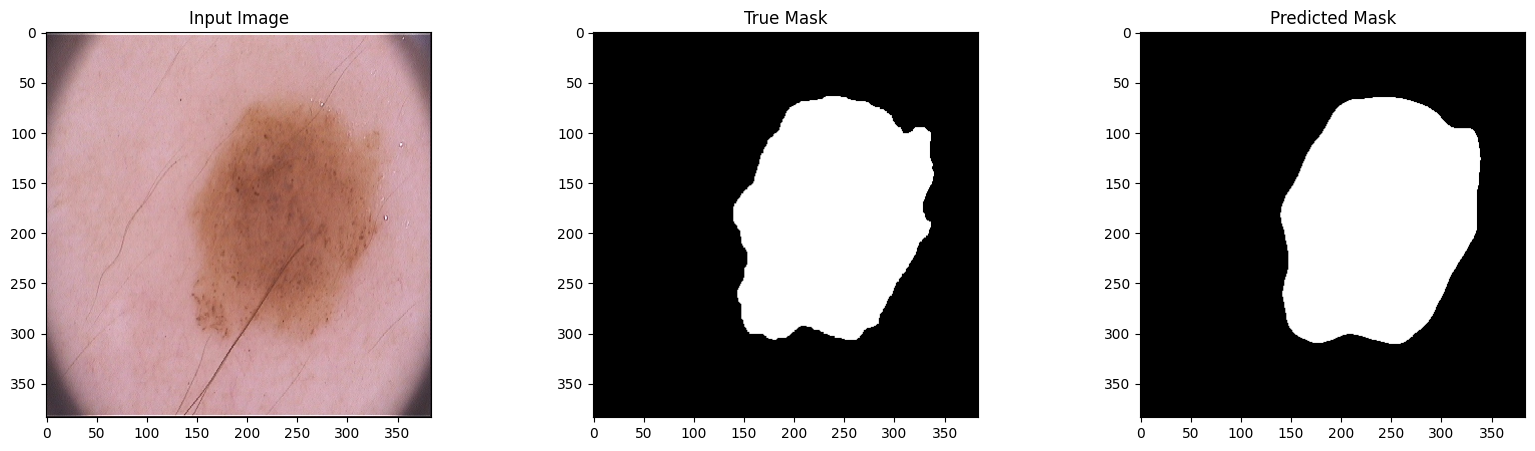

In [21]:
def load_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(384, 384))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return img

def load_mask(mask_path):
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(384, 384), color_mode="grayscale")
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    mask = mask / 255.0
    return mask
    
def plot_predictions(model, image, mask, output_dir, img_index):
    pred_mask = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.round(pred_mask[0])
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask.squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    
    # Save the figure
    result_path = os.path.join(output_dir, f'result_{img_index}.png')
    plt.savefig(result_path, bbox_inches='tight')
    plt.show()
    plt.close()

# Create output directory if it doesn't exist
output_dir = r"D:\20BPS1134\Implementation\RA\3\PH2_Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate one image
sample_index = np.random.choice(len(ph2_image_dirs), 1, replace=False)[0]
sample_image_path = ph2_image_dirs[sample_index]
sample_mask_path = ph2_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 1  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 28ms/step


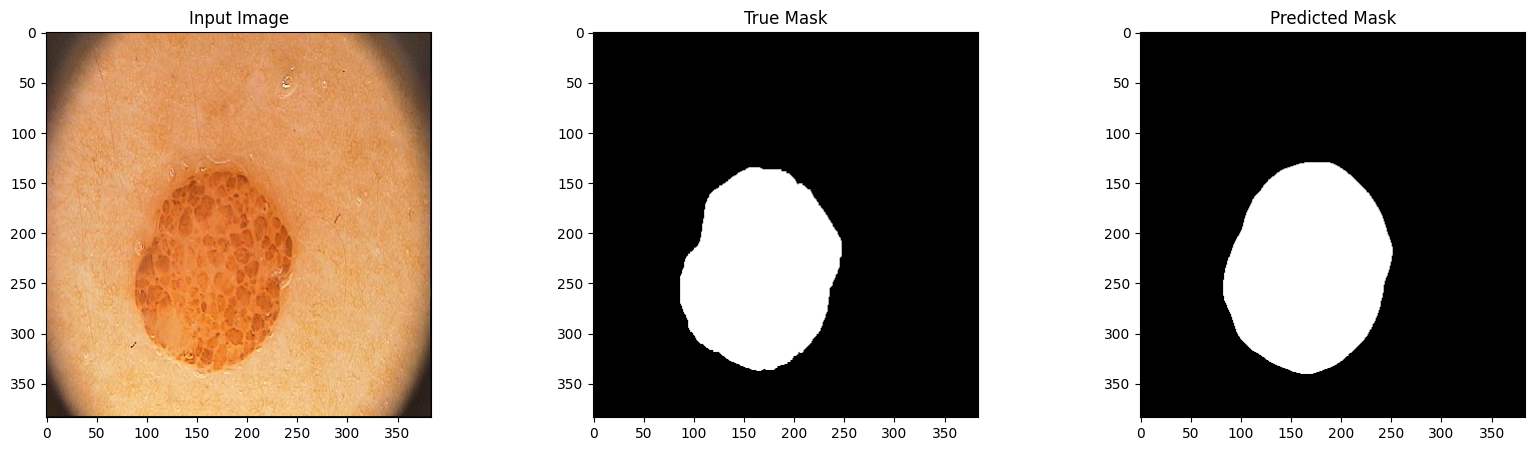

In [22]:
# Generate one image
sample_index = np.random.choice(len(ph2_image_dirs), 1, replace=False)[0]
sample_image_path = ph2_image_dirs[sample_index]
sample_mask_path = ph2_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 2  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 31ms/step


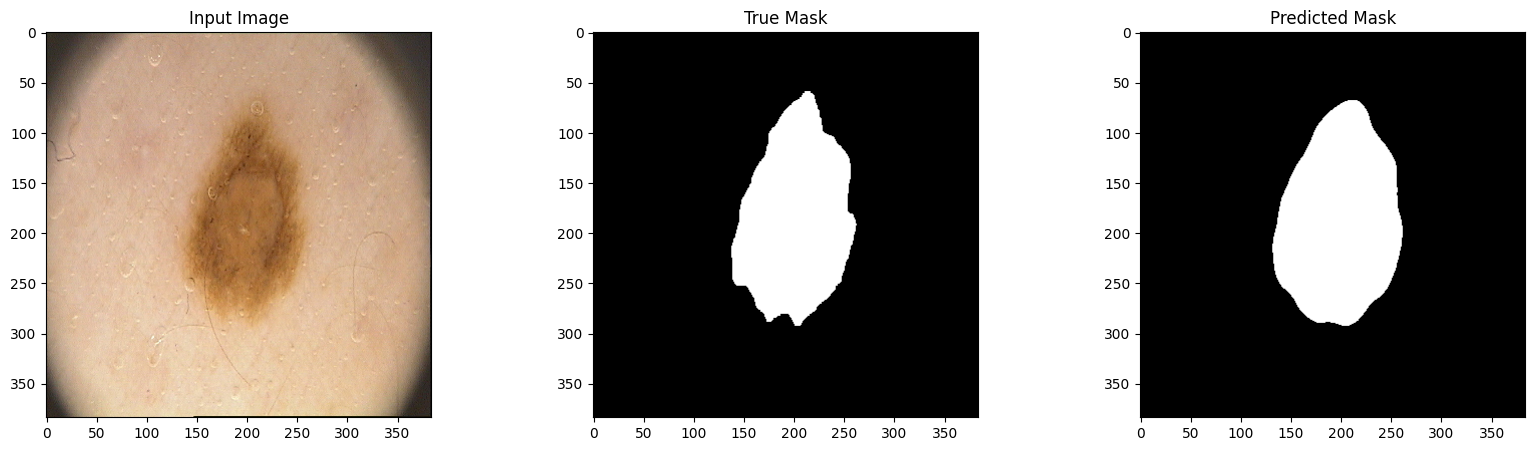

In [23]:
# Generate one image
sample_index = np.random.choice(len(ph2_image_dirs), 1, replace=False)[0]
sample_image_path = ph2_image_dirs[sample_index]
sample_mask_path = ph2_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 3  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

# TESTING THE MODEL ON DIFFERENT DATASET:- ISIC2018 DATASET

## 18.Load ISIC2018 Dataset

In [24]:
isic_base_path = r"D:\20BPS1134\ISIC2018\Extracted"
isic_base_image_path = os.path.join(isic_base_path, "ISIC2018_Task1-2_Test_Input")
isic_base_mask_path = os.path.join(isic_base_path, "ISIC2018_Task1_Test_GroundTruth")

isic_image_dirs = [os.path.join(isic_base_image_path, f) for f in os.listdir(isic_base_image_path) if f.endswith('.jpg') or f.endswith('.png')]
isic_mask_dirs = [os.path.join(isic_base_mask_path, f) for f in os.listdir(isic_base_mask_path) if f.endswith('.png')]

# Shuffle the data
combined = list(zip(isic_image_dirs, isic_mask_dirs))
np.random.shuffle(combined)
isic_image_dirs, isic_mask_dirs = zip(*combined)

## 19.Define Data Generator for ISIC2018 Dataset

In [25]:
def resize_image(image, target_size):
    return image.resize(target_size, Image.BICUBIC)

def load_image(path, target_size=(384, 384)):
    image = Image.open(path)
    image = resize_image(image, target_size)
    return img_to_array(image) / 255.0

def load_mask(path, target_size=(384, 384)):
    mask = Image.open(path).convert("L")
    mask = resize_image(mask, target_size)
    mask = img_to_array(mask) / 255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

class ISIC2018DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size=4, image_size=(384, 384), shuffle=True):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            image = load_image(img_file, self.image_size)
            mask = load_mask(mask_file, self.image_size)
            images.append(image)
            masks.append(mask)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_files, self.mask_files))
            np.random.shuffle(combined)
            self.image_files, self.mask_files = zip(*combined)

# Set the base paths
isic_base_path = r"D:\20BPS1134\ISIC2018\Extracted"
isic_base_image_path = os.path.join(isic_base_path, "ISIC2018_Task1-2_Test_Input")
isic_base_mask_path = os.path.join(isic_base_path, "ISIC2018_Task1_Test_GroundTruth")

# Get the file paths
isic_image_dirs = [os.path.join(isic_base_image_path, f) for f in os.listdir(isic_base_image_path) if f.endswith('.jpg') or f.endswith('.png')]
isic_mask_dirs = [os.path.join(isic_base_mask_path, f) for f in os.listdir(isic_base_mask_path) if f.endswith('.png')]

# Shuffle the data
combined = list(zip(isic_image_dirs, isic_mask_dirs))
np.random.shuffle(combined)
isic_image_dirs, isic_mask_dirs = zip(*combined)

# Instantiate data generator
isic_gen = ISIC2018DataGenerator(isic_image_dirs, isic_mask_dirs, batch_size=4, image_size=(384, 384))

## 20.Evaluate the Model on ISIC2018 Dataset

In [26]:
# Evaluate the model on ISIC2018 dataset
isic_loss, isic_iou, isic_fscore, isic_accuracy, isic_precision, isic_recall, isic_ssim = model.evaluate(isic_gen)
print(f"ISIC2018 Loss: {isic_loss}")
print(f"ISIC IOU Score: {isic_iou}")
print(f"ISIC FScore: {isic_fscore}")
print(f"ISIC Accuracy: {isic_accuracy}")
print(f"ISIC Precision: {isic_precision}")
print(f"ISIC Recall: {isic_recall}")
print(f"ISIC SSIM: {isic_ssim}")

250/250 [==============================] - 147s 588ms/step - loss: 0.4063 - iou_score: 0.7847 - f1-score: 0.8739 - accuracy: 5.3590e-04 - precision: 0.8444 - recall: 0.9137 - ssim_metric: 0.8769
ISIC2018 Loss: 0.4063260853290558
ISIC IOU Score: 0.7846672534942627
ISIC FScore: 0.8739405870437622
ISIC Accuracy: 0.0005359022179618478
ISIC Precision: 0.8444297313690186
ISIC Recall: 0.9136959910392761
ISIC SSIM: 0.8768521547317505


## 21.Visualize and Save Results for 3 Images from ISIC2018 Dataset

1/1 [==============================] - 0s 31ms/step


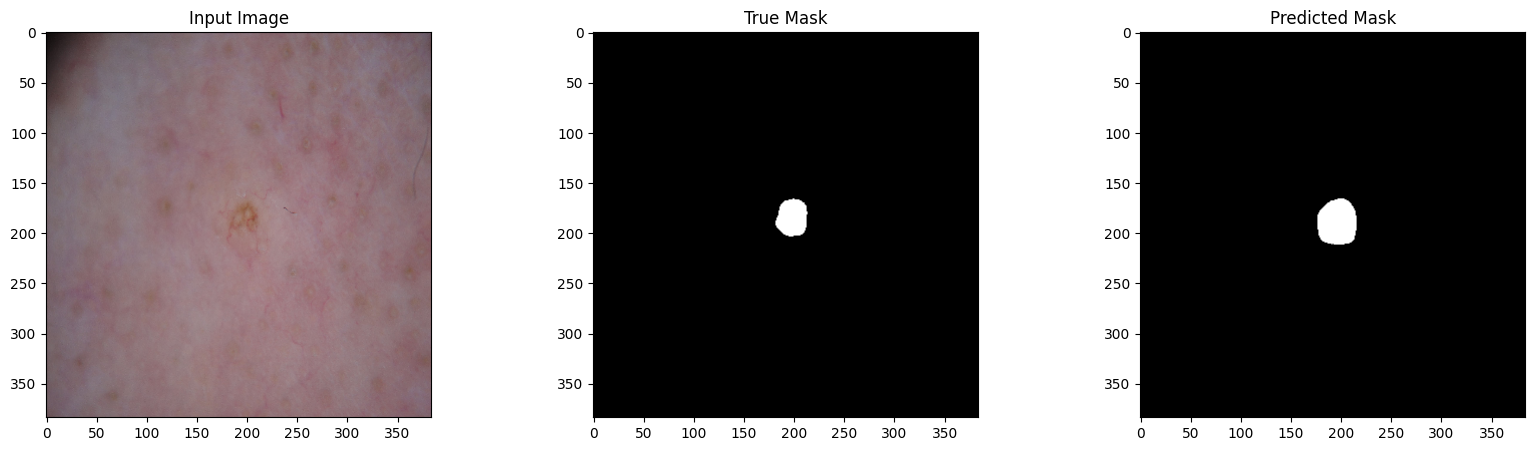

In [27]:
def load_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(384, 384))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return img

def load_mask(mask_path):
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(384, 384), color_mode="grayscale")
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    mask = mask / 255.0
    return mask
    
def plot_predictions(model, image, mask, output_dir, img_index):
    pred_mask = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.round(pred_mask[0])
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask.squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    
    # Save the figure
    result_path = os.path.join(output_dir, f'result_{img_index}.png')
    plt.savefig(result_path, bbox_inches='tight')
    plt.show()
    plt.close()

# Create output directory if it doesn't exist
output_dir = r"D:\20BPS1134\Implementation\RA\3\ISIC2018_Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate one image
sample_index = np.random.choice(len(isic_image_dirs), 1, replace=False)[0]
sample_image_path = isic_image_dirs[sample_index]
sample_mask_path = isic_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 1  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 31ms/step


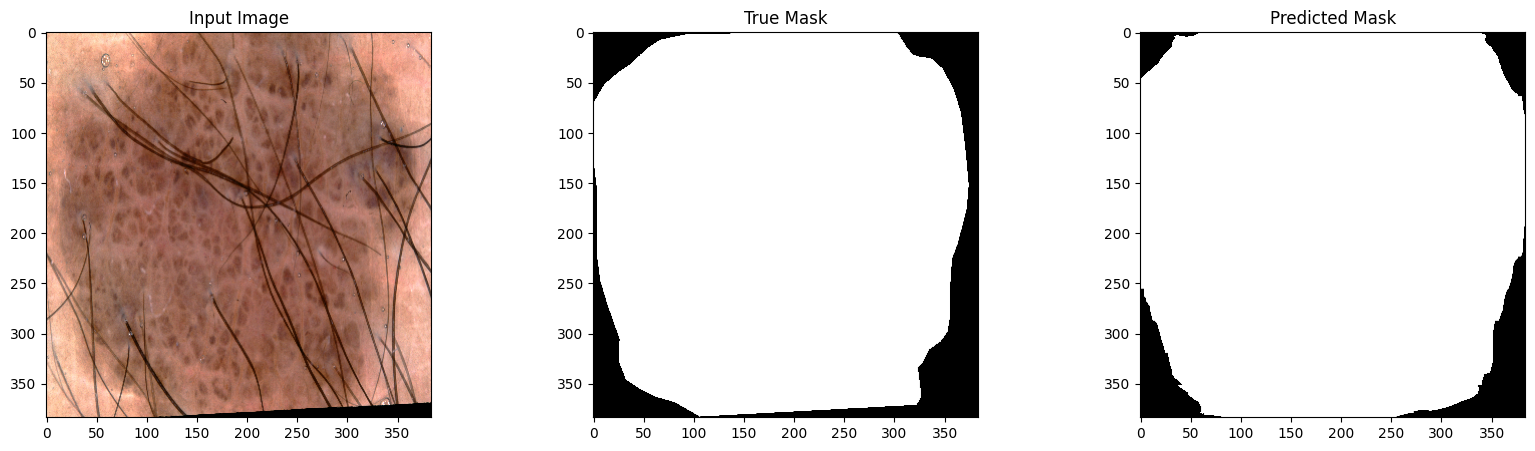

In [28]:
# Generate one image
sample_index = np.random.choice(len(isic_image_dirs), 1, replace=False)[0]
sample_image_path = isic_image_dirs[sample_index]
sample_mask_path = isic_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 2  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

1/1 [==============================] - 0s 33ms/step


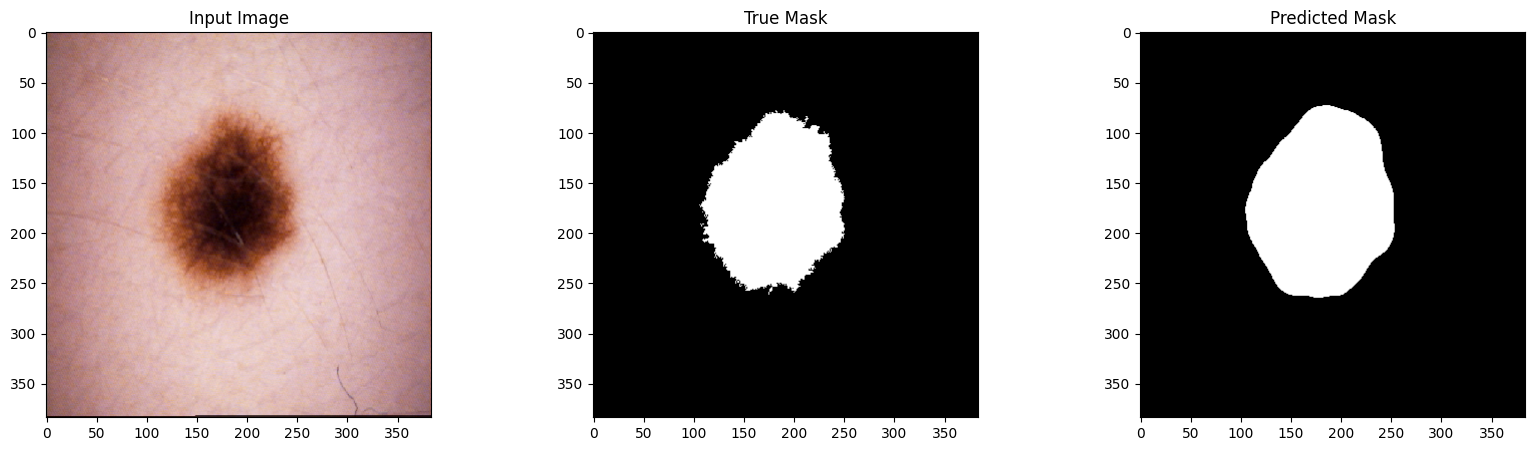

In [29]:
# Generate one image
sample_index = np.random.choice(len(isic_image_dirs), 1, replace=False)[0]
sample_image_path = isic_image_dirs[sample_index]
sample_mask_path = isic_mask_dirs[sample_index]

sample_image = load_image(sample_image_path)
sample_mask = load_mask(sample_mask_path)

# Visualize and save the result
img_index = 3  # Update this index for each cell: 1, 2, and 3
plot_predictions(model, sample_image, sample_mask, output_dir, img_index)

## Time Tracking Calculation

In [30]:
# Record the end time
end_time = datetime.datetime.now()
print(f"Notebook ended at: {end_time}")

# Calculate the total runtime
total_runtime = end_time - start_time
print(f"Total runtime: {total_runtime}")

Notebook ended at: 2024-07-18 03:08:44.745902
Total runtime: 10:10:28.101339
